In [1]:
#Library Imports

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud, STOPWORDS
import numpy as np
from collections import defaultdict

In [2]:
#Data import
df = pd.read_excel('ground_vehicles.xlsx')

In [3]:
#Observing data types, objects likely represent presence of null values
df.dtypes

ID                              int64
Contract Number (IDVPIID)      object
Award Number (PIID)            object
Modification Number            object
Fiscal Year                     int64
Title                          object
Awarded Amount                float64
Contracting Office             object
Contracting Agency             object
Place of Performance State     object
Place of Performance City      object
Vendor  Name                   object
Vendor  Top Name               object
PSC Name                       object
dtype: object

In [4]:
#Checking for null values
df.isna().sum()

ID                                0
Contract Number (IDVPIID)     14277
Award Number (PIID)             125
Modification Number            1484
Fiscal Year                       0
Title                             3
Awarded Amount                 1298
Contracting Office                0
Contracting Agency                0
Place of Performance State     2372
Place of Performance City      2372
Vendor  Name                      0
Vendor  Top Name                  0
PSC Name                        748
dtype: int64

In [5]:
len(df)

54379

In [6]:
#ID is unique identifier, contract number and award numbers are not entirely unique, possibly multi-indexed
df.nunique()

ID                            54379
Contract Number (IDVPIID)       675
Award Number (PIID)           34389
Modification Number             682
Fiscal Year                       6
Title                         40918
Awarded Amount                28665
Contracting Office              620
Contracting Agency               80
Place of Performance State       53
Place of Performance City       751
Vendor  Name                   1131
Vendor  Top Name               1034
PSC Name                        523
dtype: int64

In [7]:
#Convert non null ID columns to strings
df.loc[df["Contract Number (IDVPIID)"].notna(), "Contract Number (IDVPIID)"] = df["Contract Number (IDVPIID)"].astype(str)
df.loc[df["Award Number (PIID)"].notna(), "Award Number (PIID)"] = df["Award Number (PIID)"].astype(str)
df.loc[df["Modification Number"].notna(), "Modification Number"] = df["Modification Number"].astype(str)

## Vendor Name Normalization

In [8]:
#Inspection of vendor name column
df["Vendor  Name"].value_counts().head(45)

Vendor  Name
Howmedica Osteonics Corp.                               32953
Beacon Point Associates LLC                              2806
Stryker Corporation                                      2252
Physio-Control, Inc.                                     1608
General Dynamics Land Systems Inc.                       1204
Stryker Sales, LLC                                       1076
Oshkosh Corporation                                       591
Bae Systems Land & Armaments L.P.                         546
Trillamed, LLC                                            388
Abrams Airborne Manufacturing, Inc.                       386
Raytheon Company                                          310
Science Applications International Corporation            277
Ost, Inc.                                                 272
Mercom, Incorporated                                      269
Canadian Commercial Corporation                           266
K2m, Inc.                                                

In [9]:
#Inspection of vendor top name column
df['Vendor  Top Name'].value_counts().head(45)

Vendor  Top Name
Stryker Corporation                               38416
Beacon Point Associates LLC                        2806
General Dynamics Corporation                       1104
BAE SYSTEMS PLC                                     570
General Dynamics Corp.                              508
Oshkosh Corporation                                 468
Trillamed, LLC                                      388
Abrams Airborne Manufacturing, Inc.                 386
Raytheon Technologies Corporation                   379
Science Applications International Corporation      317
Northrop Grumman Corporation                        281
Ost, Inc.                                           272
Mercom, Incorporated                                269
Government of Canada                                263
The Boeing Company                                  245
Caterpillar Inc.                                    233
American Purchasing Services, LLC                   231
Countertrade Products, Inc.    

In [10]:
#Clear that most final terms can be removed for the sake of normalization, manual inspection 
df["Vendor Name Ending"] = df["Vendor  Name"].str.split().str[-1].str.lower()
print(df["Vendor Name Ending"].nunique())
print(df["Vendor Name Ending"].value_counts().to_dict())

143
{'corp.': 32997, 'inc.': 7554, 'llc': 6270, 'corporation': 4118, 'inc': 622, 'l.p.': 606, 'incorporated': 408, 'company': 387, 'l.l.c.': 173, 'ltda': 109, 'co.': 98, 'venture': 80, 'university': 70, 'abrams': 61, 's': 59, 'a': 51, 'co': 47, 'systems': 40, 'virginia)': 37, 'college': 36, 'venture,': 35, 'kg': 30, 'jv': 30, 'l.c.': 30, 'awardees': 23, 'limited': 23, 'corp': 21, 'o': 18, 'varec': 18, 'lp': 17, 'ltd': 16, 'ltd.': 15, 'carrera': 11, 'industries': 10, 'technologies': 9, 'gmbh': 8, 'as': 8, 'thor': 6, 'eisman': 6, 'pllc': 6, 'b.v.': 6, 'kidde': 6, 'reynolds': 5, 'tek': 5, 'srl': 5, 'warszawa': 5, 'illinois': 5, 'nv,antwerpsesteenweg': 5, 'mi': 4, 'hunt': 4, 'pennsylvania': 4, 'enterprises': 4, 'solutions': 4, 'linen': 4, 'llc.': 4, 'schuller': 4, 'yeam': 3, 'mbh': 3, 'development': 3, 'internati': 3, 'l.l.l.p.': 3, 'morris': 3, 'sas': 3, 'e.i.r.l.': 3, 'group': 3, '(undisclosed)': 3, 'medical': 3, 'cr': 3, 'martin': 3, 'international': 3, 'bradley': 3, 'lc': 2, 'fanatics'

In [11]:
#List of general stopwords to filter out of vendor names (only applies to the end)
vendor_stopwords = {
    'corp.', 'inc.', 'llc', 'corporation', 'inc', 'l.p.', 'incorporated',
    'company', 'l.l.c.', 'ltda', 'co.', 'venture',
    'kg', 'jv', 'l.c.', 'awardees', 'limited', 'corp', 'lp', 'ltd', 'ltd.',
    'pllc', 'b.v.', 'srl', 'mbh', 'sas', 'e.i.r.l.', 'group',
    'international', 'enterprises', 'solutions', 'development', 'foundation',
    'services', 'service', 'engineering', 'technologies', 'technology',
    'industries', 'equipment', 'machining', 'fabricating', 'construction',
    'electronics', 'products', 'systems', 'system', 'the', 'dba',
    'co', 'lc', 'ulc', 'plc', 'gmbh', 'l.l.l.p.', 'llc.', 'distributors', 'sales',
}


In [12]:
#Make vendor name lowercase, remove punctuation, remove terminating stopwords
def normalize_vendor_name(name, stopwords):
    if pd.isna(name):
        return ''
    
    name = name.lower()
    name = re.sub(r'[^\w\s]', '', name) 
    tokens = name.split()

    while tokens and tokens[-1] in stopwords:
        tokens.pop()

    return ' '.join(tokens)

In [13]:
df['Vendor Normalized'] = df['Vendor  Name'].apply(lambda x: normalize_vendor_name(x, vendor_stopwords))

## Aggregation of Award Amounts

In [14]:
#Creating df_final that only includes one row per contract, summing across all awards. Will be used for some visuals but generally will stick to df
df["Contract Number (IDVPIID)"] = df["Contract Number (IDVPIID)"].fillna("0")
df["Modification Number"] = df["Modification Number"].fillna("0")

award_sums = (df.groupby(["Contract Number (IDVPIID)", "Award Number (PIID)"], as_index=False)["Awarded Amount"].sum().rename(columns={"Awarded Amount": "Total Awarded Amount"}))

df_sorted = df.sort_values(by=["Contract Number (IDVPIID)", "Award Number (PIID)", "ID"])

df_first_mod = (df_sorted.groupby(["Contract Number (IDVPIID)", "Award Number (PIID)"]).first().reset_index())

df_final = df_first_mod.merge(award_sums, on=["Contract Number (IDVPIID)", "Award Number (PIID)"], how="left")

df_final["Total Awarded Amount"] = df_final["Total Awarded Amount"].fillna(df_final["Awarded Amount"])


## Quick Visuals

In [15]:
#Filter years of interest
df_final = df_final[df_final["Fiscal Year"].isin([2016, 2017, 2018, 2019, 2020])]
df= df[df["Fiscal Year"].isin([2016, 2017, 2018, 2019, 2020])]

In [16]:
df["PSC Name"].value_counts()

PSC Name
(6640) LABORATORY EQUIPMENT AND SUPPLIES                                                            21370
(6515) MEDICAL AND SURGICAL INSTRUMENTS, EQUIPMENT, AND SUPPLIES                                    14104
(2350) COMBAT, ASSAULT, AND TACTICAL VEHICLES, TRACKED                                                915
(R425) SUPPORT- PROFESSIONAL: ENGINEERING/TECHNICAL                                                   811
(J065) MAINT/REPAIR/REBUILD OF EQUIPMENT- MEDICAL, DENTAL, AND VETERINARY EQUIPMENT AND SUPPLIES      788
                                                                                                    ...  
(AJ44) R&D- GENERAL SCIENCE/TECHNOLOGY: ENGINEERING (ENGINEERING DEVELOPMENT)                           1
(Z2EB) REPAIR OR ALTERATION OF MAINTENANCE BUILDINGS                                                    1
(AZ14) R&D- OTHER RESEARCH AND DEVELOPMENT (ENGINEERING DEVELOPMENT)                                    1
(14) GUIDED MISSILES                 

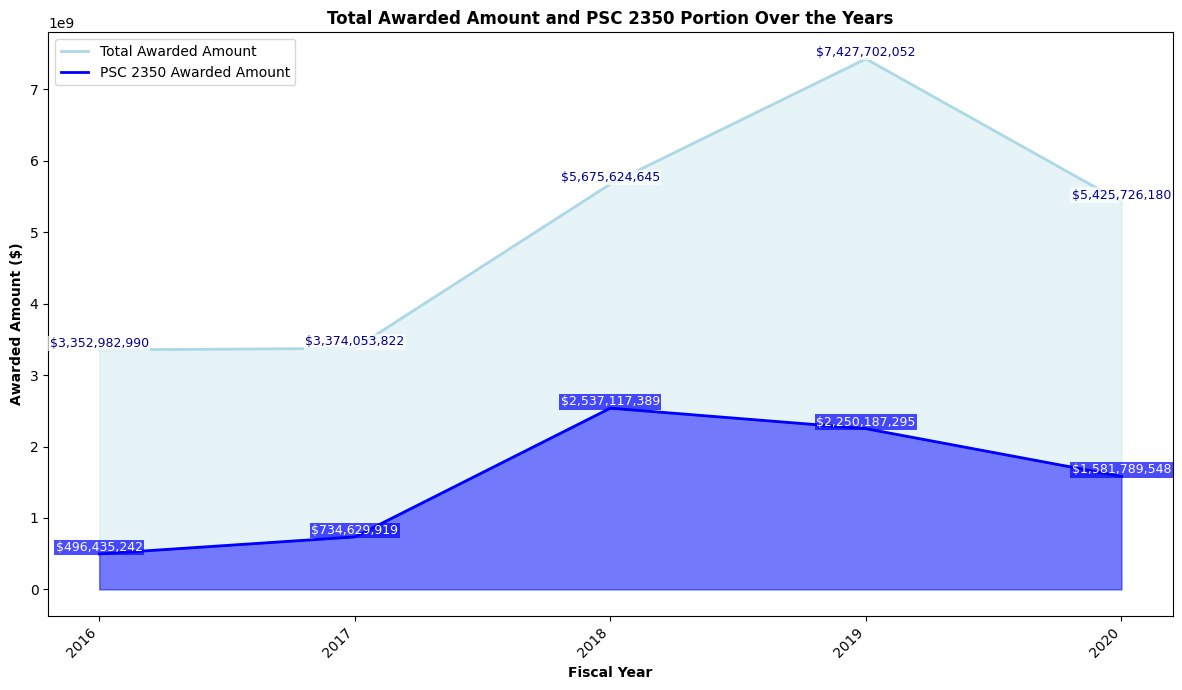

/var/folders/4z/llvfppw90ydchwbr1fv8xb0m0000gn/T/ipykernel_9382/964659965.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(data=top_vendors, x="Vendor Normalized", y="Total Awarded Amount", palette='Blues_d')


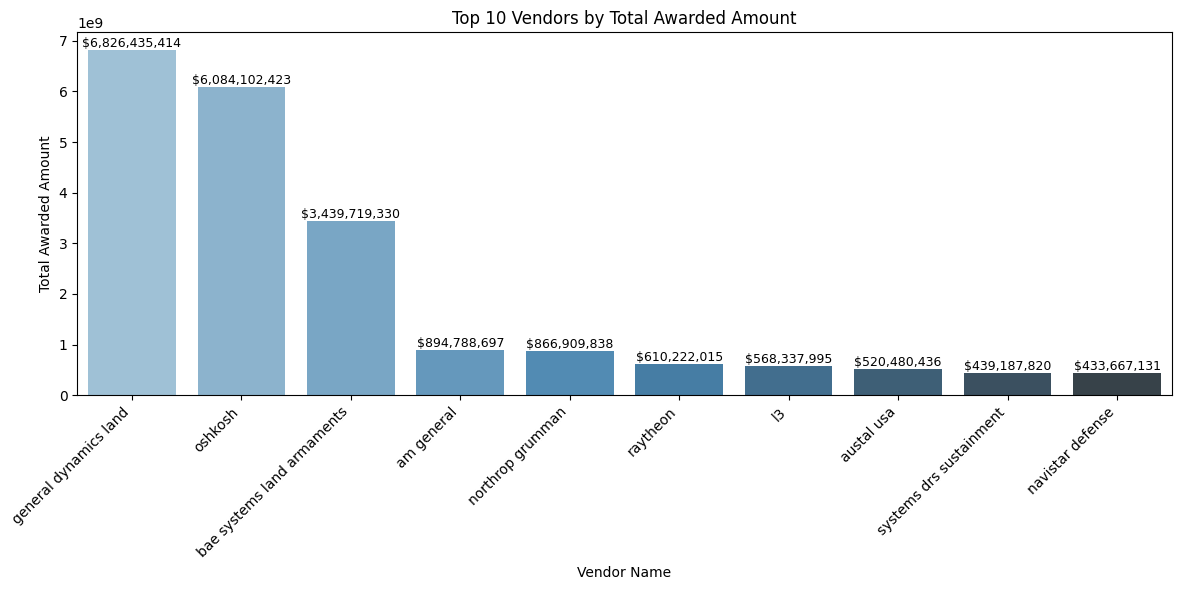

In [17]:
#First plot presents the total spending per year as well as the total spending for PSC category 2350 which relates to vehicles, second represents the top vendors in total

fiscal_grouped = df.groupby("Fiscal Year")["Awarded Amount"].sum().reset_index()

psc_2350_yearly = df[df['PSC Name'] == '(2350) COMBAT, ASSAULT, AND TACTICAL VEHICLES, TRACKED']
psc_2350_yearly_sum = psc_2350_yearly.groupby("Fiscal Year")["Awarded Amount"].sum().reset_index()

fiscal_grouped = fiscal_grouped.merge(psc_2350_yearly_sum, on='Fiscal Year', how='left', suffixes=('', '_2350'))
fiscal_grouped['Awarded Amount_2350'] = fiscal_grouped['Awarded Amount_2350'].fillna(0)
fiscal_grouped['Fiscal Year'] = fiscal_grouped['Fiscal Year'].astype(str)

plt.figure(figsize=(12, 7)) 

ax = sns.lineplot(data=fiscal_grouped, x="Fiscal Year", y="Awarded Amount", color='lightblue', label='Total Awarded Amount', linewidth=2,)

plt.fill_between(fiscal_grouped['Fiscal Year'],fiscal_grouped['Awarded Amount'], color='lightblue', alpha=0.3,)

sns.lineplot(data=fiscal_grouped, x="Fiscal Year", y="Awarded Amount_2350", color='blue', label='PSC 2350 Awarded Amount', linewidth=2,)

plt.fill_between(fiscal_grouped['Fiscal Year'], fiscal_grouped['Awarded Amount_2350'], color='blue', alpha=0.5,)

for i, row in fiscal_grouped.iterrows():
    plt.text(row['Fiscal Year'], row['Awarded Amount'], f"${row['Awarded Amount']:,.0f}", ha='center', va='bottom', fontsize=9, color='darkblue', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1),)

for i, row in fiscal_grouped.iterrows():
    if row['Awarded Amount_2350'] > 0:
        plt.text(row['Fiscal Year'],row['Awarded Amount_2350'],f"${row['Awarded Amount_2350']:,.0f}",ha='center',va='bottom',fontsize=9,color='white',bbox=dict(facecolor='blue', alpha=0.7, edgecolor='none', pad=1),)

plt.title("Total Awarded Amount and PSC 2350 Portion Over the Years", fontweight='bold')
plt.xlabel("Fiscal Year", fontweight='bold')
plt.ylabel("Awarded Amount ($)", fontweight='bold')
plt.xticks(rotation=45, ha='right')

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


top_vendors = df_final.groupby('Vendor Normalized')["Total Awarded Amount"].sum().reset_index()
top_vendors = top_vendors.sort_values(by="Total Awarded Amount", ascending=False).head(10)

plt.figure(figsize=(12, 6))
ax2 = sns.barplot(data=top_vendors, x="Vendor Normalized", y="Total Awarded Amount", palette='Blues_d')

for bar in ax2.patches:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2,height,f"${height:,.0f}",ha='center',va='bottom',fontsize=9)

plt.title("Top 10 Vendors by Total Awarded Amount")
plt.xlabel("Vendor Name")
plt.ylabel("Total Awarded Amount")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Null/Missing investigation

In [18]:
df[df["Awarded Amount"].isna()]

,ID,Contract Number (IDVPIID),Award Number (PIID),Modification Number,Fiscal Year,Title,Awarded Amount,Contracting Office,Contracting Agency,Place of Performance State,Place of Performance City,Vendor Name,Vendor Top Name,PSC Name,Vendor Name Ending,Vendor Normalized
0,261901205,0,SPE4A616M0117,0,2016,"BEARING,PLAIN,SPHER",NaN,DLA Aviation (formerly Defense Supply Center R...,US Department of Defense (DoD),NaN,NaN,Longhorn Regional Service Center LLC,Longhorn Regional Service Center LLC,(31) BEARINGS,llc,longhorn regional service center
22,262000126,0,SPE4A616F0002,0,2016,"MODIFICATION KIT,CO",NaN,DLA Aviation (formerly Defense Supply Center R...,US Department of Defense (DoD),NaN,NaN,"L3harris Technologies, Inc.","L3harris Technologies, Inc.","(58) COMMUNICATION, DETECTION, AND COHERENT RA...",inc.,l3harris
23,262000315,0,SPE2DS16M0038,0,2016,"FIXATION SET,EXTERNAL,ORTHOPEDIC",NaN,DLA Troop Support - Medical,US Department of Defense (DoD),NaN,NaN,Howmedica Osteonics Corp.,Stryker Corporation,"(65) MEDICAL, DENTAL, AND VETERINARY EQUIPMENT...",corp.,howmedica osteonics
24,262000421,0,VA263-15-C-0156,0,2016,Stryker Bed Maintenance Agreement Base Plus 4 ...,NaN,Sioux Falls VA Health Care System,US Department of Veterans Affairs (VA),NaN,NaN,Stryker Corporation,Stryker Corporation,"(J) MAINTENANCE, REPAIR, AND REBUILDING OF EQU...",corporation,stryker
39,262035006,0,W56HZV16D0014,0,2016,"VEHICULAR BRAKE, STEERING, AXLE, WHEEL, AND TR...",NaN,ACC Warren Contracting Center (ACC-WRN),US Department of Defense (DoD),NaN,NaN,Seco Parts & Equipment Company,SECO PARTS & EQUIPMENT COMPANY,(25) VEHICULAR EQUIPMENT COMPONENTS,company,seco parts
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46169,633283855,0,SPE7LX20D0226,0,2020,"WIRING HARNESS, BRAN",NaN,Defense Logistics Agency (DLA),US Department of Defense (DoD),NaN,NaN,"Semco Instruments, Inc.",Transdigm Group Incorporated,NaN,inc.,semco instruments
46170,633297190,0,N0024420P0205,0,2020,1385 - Post Award Synopsis for Sole Source Pur...,NaN,US Department of the Navy,US Department of Defense (DoD),NaN,NaN,"Flir Unmanned Ground Systems, Inc.",Teledyne Technologies Inc,(1385) SURFACE USE EXPLOSIVE ORDNANCE DISPOSAL...,inc.,flir unmanned ground
46806,635168591,0,N6600120C4703,0,2020,Multi-Modal Sensing Network,NaN,US Department of the Navy,US Department of Defense (DoD),VA,Annandale,"Titan One Zero, LLC","Titan One Zero, LLC",(A) RESEARCH AND DEVELOPMENT,llc,titan one zero
48793,650750987,0,T100365,0,2019,ASSIGNMENT OF T100332 TO STRYK,NaN,State University of New York at Stony Brook,State of New York,NaN,NaN,"Stryker Sales, LLC",Stryker Corporation,NaN,llc,stryker


In [19]:
#All null award amounts have missing contract numbers (only 1 unique value of 0 which was set earlier for missing values)
df[df["Awarded Amount"].isna()]["Contract Number (IDVPIID)"].nunique()

1

In [20]:
df.isna().sum()

ID                               0
Contract Number (IDVPIID)        0
Award Number (PIID)            121
Modification Number              0
Fiscal Year                      0
Title                            2
Awarded Amount                1235
Contracting Office               0
Contracting Agency               0
Place of Performance State    2220
Place of Performance City     2220
Vendor  Name                     0
Vendor  Top Name                 0
PSC Name                       693
Vendor Name Ending               0
Vendor Normalized                0
dtype: int64

In [21]:
#Find the contracts in which there is both a null and non-null award amount. In this case there are 572 of them, leading me to believe that many of these missing values pertain to updates for other contracts, and warrant their inclusion in the data. I will set the awarded amount to 0.
contract_award_na_mix = (df.groupby("Award Number (PIID)")["Awarded Amount"].agg(['count', lambda x: x.isna().sum(), lambda x: x.notna().sum()]).rename(columns={"<lambda_0>": "Num_Nulls","<lambda_1>": "Num_Non_Nulls"}))

contract_award_na_mix = contract_award_na_mix[(contract_award_na_mix["Num_Nulls"] > 0) & (contract_award_na_mix["Num_Non_Nulls"] > 0)]

print(len(contract_award_na_mix.index))


572


In [22]:
contract_award_na_mix.sort_values(by="Num_Nulls", ascending=False)

,count,Num_Nulls,Num_Non_Nulls
Award Number (PIID),,,
SP330018P0169,6,4,6
SP330016M0954,4,3,4
SPE2DS18P2517,1,2,1
SPE7M920C0002,1,2,1
SPE7L420V0534,1,2,1
...,...,...,...
SPE2DS16V1950,1,1,1
SPE2DS16V1896,1,1,1
SPE2DS16V1868,1,1,1


In [23]:
df.loc[(df["Award Number (PIID)"].isin(contract_award_na_mix.index)) & (df["Awarded Amount"].isna()),"Awarded Amount"] = 0

In [24]:
#Awarded amount null value decreases to 632 from 1235
df.isna().sum()

ID                               0
Contract Number (IDVPIID)        0
Award Number (PIID)            121
Modification Number              0
Fiscal Year                      0
Title                            2
Awarded Amount                 632
Contracting Office               0
Contracting Agency               0
Place of Performance State    2220
Place of Performance City     2220
Vendor  Name                     0
Vendor  Top Name                 0
PSC Name                       693
Vendor Name Ending               0
Vendor Normalized                0
dtype: int64

In [25]:
contract_award_na_mix = (df.groupby("Award Number (PIID)")["Awarded Amount"].agg(['count', lambda x: x.isna().sum(), lambda x: x.notna().sum()]).rename(columns={"<lambda_0>": "Num_Nulls","<lambda_1>": "Num_Non_Nulls"}))

contract_award_na_mix = contract_award_na_mix[(contract_award_na_mix["Num_Nulls"] > 0) & (contract_award_na_mix["Num_Non_Nulls"] > 0)]

print(len(contract_award_na_mix.index))


0


In [26]:
df[df["Awarded Amount"].isna()].sort_values(by="Award Number (PIID)")

,ID,Contract Number (IDVPIID),Award Number (PIID),Modification Number,Fiscal Year,Title,Awarded Amount,Contracting Office,Contracting Agency,Place of Performance State,Place of Performance City,Vendor Name,Vendor Top Name,PSC Name,Vendor Name Ending,Vendor Normalized
15554,303974241,0,11017063,0,2017,Sleeper Chair for Hospital Rooms,NaN,US Department of the Army,US Department of Defense (DoD),NaN,NaN,Logistics Network Inc.,Logistics Network Inc.,"(65) MEDICAL, DENTAL, AND VETERINARY EQUIPMENT...",inc.,logistics network
27497,464356139,0,140A1618P0229,0,2018,Books and AudioVisual Equipment,NaN,BIA - DAPM,US Department of the Interior (DOI),NaN,NaN,"Beecon Learning, LLC","Beecon Learning, LLC","(76) BOOKS, MAPS, AND OTHER PUBLICATIONS",llc,beecon learning
45778,631039034,0,15B61520PVBF130177,0,2020,PERFORMANCE PRO STRYKER GURNEY,NaN,Bureau of Prisons (BOP),US Department of Justice (DOJ),AZ,Tucson,"Trillamed, LLC","Trillamed, LLC","(6515) MEDICAL AND SURGICAL INSTRUMENTS, EQUIP...",llc,trillamed
7625,287973408,0,16-P-0050,0,2016,Corrosion Covers,NaN,US Department of the Army,US Department of Defense (DoD),NaN,NaN,"Transhield, Inc.","Transhield, Inc.","(83) TEXTILES, LEATHER, FURS, APPAREL AND SHOE...",inc.,transhield
7630,288199162,0,16-P-0060,0,2016,Corrosion Covers,NaN,US Department of the Army,US Department of Defense (DoD),NaN,NaN,"Transhield, Inc.","Transhield, Inc.","(83) TEXTILES, LEATHER, FURS, APPAREL AND SHOE...",inc.,transhield
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37910,577960454,0,NaN,0,2016,RFT - Lake Street/Russell Avenue,NaN,City of St. Catharines,City of St. Catharines,NaN,NaN,Peter's Excavating,Peter's Excavating,NaN,excavating,peters excavating
39273,583368520,0,NaN,0,2019,Road Construction - Western Region,NaN,Department of Agriculture,State of Maine,NaN,NaN,Mt. Abram Excavating Co.,Mt. Abram Excavating Co.,NaN,co.,mt abram excavating
43333,609113643,0,NaN,0,2020,SUPPLY OF M113 SPARES,NaN,North Atlantic Treaty Organization - Support A...,North Atlantic Treaty Organization,NaN,NaN,Varec,Amret,NaN,varec,varec
44613,625318530,0,NaN,0,2020,Purchase of Stryker Medical Equipment,NaN,St. Johns County,St. Johns County,NaN,NaN,"Stryker Sales, LLC",Stryker Corporation,NaN,llc,stryker


In [27]:
#Will set other missing values aside, store them in a seperate df in the case that they warrant analysis later
df_na = df[df["Awarded Amount"].isna()]
df = df.dropna(subset=["Awarded Amount"])

In [28]:
#Creating narrower datasets for the 3 programs of interest based on title, such filtering is likely not perfect but I find captures a heavy proportion of related spending
stryker =  df[df["Title"].str.lower().str.contains("stryker vehicle", na=False)]
abrams_tank = df[df["Title"].str.lower().str.contains("abrams tank", na=False)]
bradley =  df[df["Title"].str.lower().str.contains("bradley", na=False)]

In [29]:
#Generating word frequencies in titles over the years for the programs
custom_stopwords = set(STOPWORDS)

word_freqs = defaultdict(lambda: defaultdict(dict))

datasets = {'Bradley': bradley, 'Abrams_Tank': abrams_tank, 'Stryker': stryker}

for program_name, df_input in datasets.items():
    df_wc = df_input[~df['Title'].isna()]
    for year in sorted(df_wc['Fiscal Year'].dropna().unique()):
        yearly_text = ' '.join(df_wc[df_wc['Fiscal Year'] == year]['Title'].dropna().astype(str))

        wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=custom_stopwords, colormap='Blues').generate(yearly_text)
        word_freqs[program_name][year] = wordcloud.words_

/var/folders/4z/llvfppw90ydchwbr1fv8xb0m0000gn/T/ipykernel_9382/472142171.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_wc = df_input[~df['Title'].isna()]
/var/folders/4z/llvfppw90ydchwbr1fv8xb0m0000gn/T/ipykernel_9382/472142171.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_wc = df_input[~df['Title'].isna()]
/var/folders/4z/llvfppw90ydchwbr1fv8xb0m0000gn/T/ipykernel_9382/472142171.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_wc = df_input[~df['Title'].isna()]


In [30]:
word_freqs

defaultdict(<function __main__.<lambda>()>,
            {'Bradley': defaultdict(dict,
                         {2016: {'BRADLEY': 1.0,
                           'CLIN': 0.7692307692307693,
                           'SYSTEM': 0.5,
                           'VEHICLE': 0.4230769230769231,
                           'FIGHTING VEHICLE': 0.4230769230769231,
                           'SUPPORT': 0.38461538461538464,
                           'TEST': 0.38461538461538464,
                           'BRADLEY FIGHTING': 0.34615384615384615,
                           'NSN': 0.2692307692307692,
                           'CONTRACT': 0.2692307692307692,
                           'HILUX': 0.2692307692307692,
                           'SYSTEM TECHNICAL': 0.2692307692307692,
                           'TECHNICAL SUPPORT': 0.2692307692307692,
                           'ABRAM': 0.23076923076923078,
                           'IGF OT': 0.23076923076923078,
                           'OT IGF': 0.23

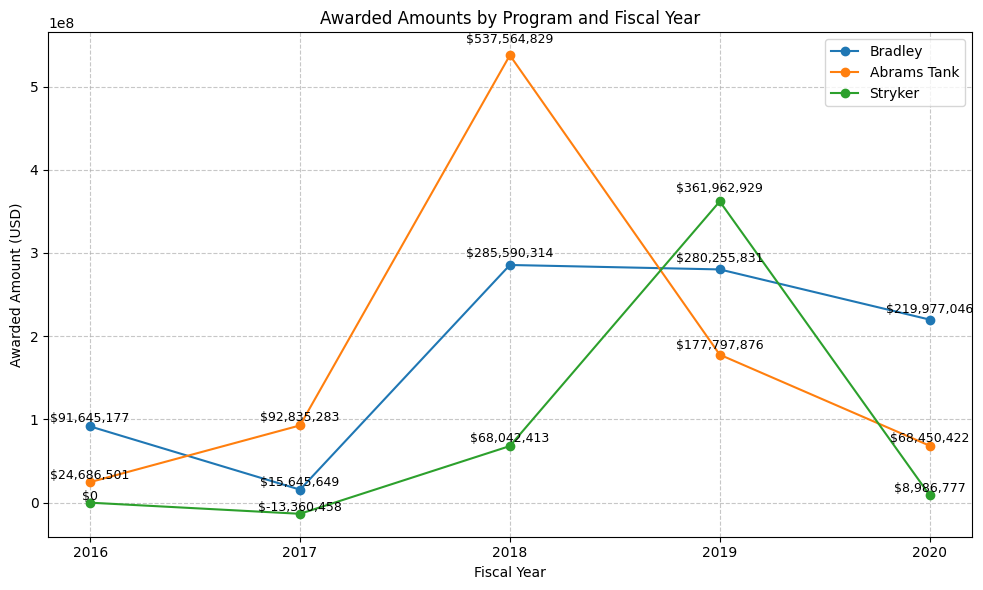

In [31]:
#Awarded amount for each program over the years, Bradley is very steady, large spike for Abrams in 2018, 2019 Stryker spike
bradley_grouped = bradley.groupby('Fiscal Year', as_index=False)['Awarded Amount'].sum()
abrams_grouped = abrams_tank.groupby('Fiscal Year', as_index=False)['Awarded Amount'].sum()
stryker_grouped = stryker.groupby('Fiscal Year', as_index=False)['Awarded Amount'].sum()
bradley_grouped.rename(columns={'Awarded Amount': 'Bradley'}, inplace=True)
abrams_grouped.rename(columns={'Awarded Amount': 'Abrams_Tank'}, inplace=True)
stryker_grouped.rename(columns={'Awarded Amount': 'Stryker'}, inplace=True)
merged = bradley_grouped.merge(abrams_grouped, on='Fiscal Year', how='outer').merge(stryker_grouped, on='Fiscal Year', how='outer').sort_values('Fiscal Year')
merged["Fiscal Year"] = merged["Fiscal Year"].astype(str)

plt.figure(figsize=(10, 6))
for program in ['Bradley', 'Abrams_Tank', 'Stryker']:
    plt.plot(merged['Fiscal Year'], merged[program], marker='o', label=program.replace('_', ' '))
    for x, y in zip(merged['Fiscal Year'], merged[program]):
        if pd.notna(y):
            plt.text(x, y*1.02, f'${y:,.0f}', fontsize=9, ha='center', va='bottom')


plt.title('Awarded Amounts by Program and Fiscal Year')
plt.xlabel('Fiscal Year')
plt.ylabel('Awarded Amount (USD)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


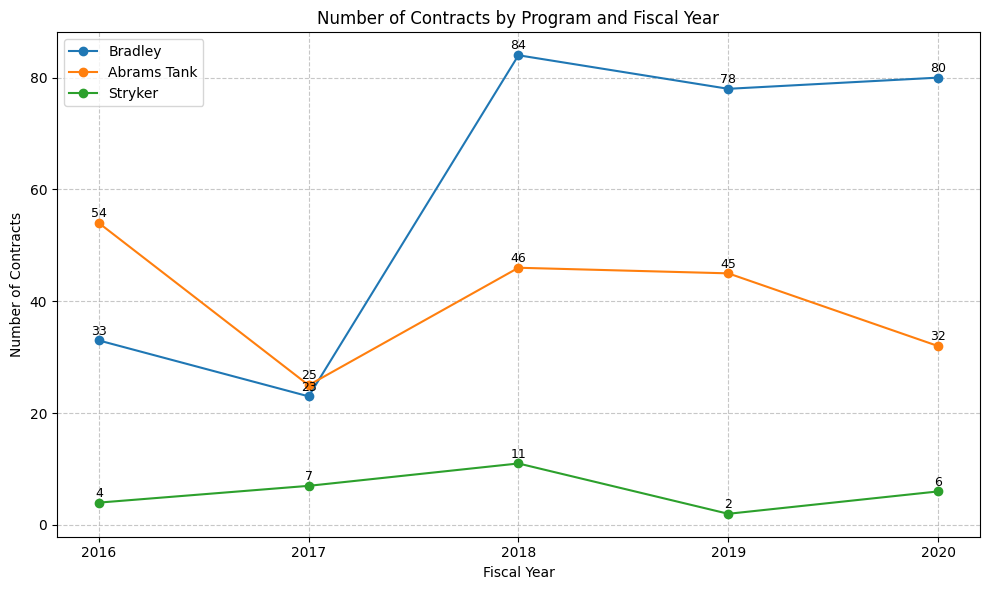

In [32]:
#Number of contracts per vehicle per year. Bradley consistently the highest even in lower spending years compared to Abrams
bradley_counts = bradley.groupby('Fiscal Year', as_index=False).size()
abrams_counts = abrams_tank.groupby('Fiscal Year', as_index=False).size()
stryker_counts = stryker.groupby('Fiscal Year', as_index=False).size()
bradley_counts.rename(columns={'size': 'Bradley'}, inplace=True)
abrams_counts.rename(columns={'size': 'Abrams_Tank'}, inplace=True)
stryker_counts.rename(columns={'size': 'Stryker'}, inplace=True)

count_merged = bradley_counts.merge(abrams_counts, on='Fiscal Year', how='outer').merge(stryker_counts, on='Fiscal Year', how='outer').sort_values('Fiscal Year')
count_merged["Fiscal Year"] = count_merged["Fiscal Year"].astype(str)
plt.figure(figsize=(10, 6))

for program in ['Bradley', 'Abrams_Tank', 'Stryker']:
    plt.plot(count_merged['Fiscal Year'], count_merged[program], marker='o', label=program.replace('_', ' '))
    for x, y in zip(count_merged['Fiscal Year'], count_merged[program]):
        if pd.notna(y):
            plt.text(x, y+.5, f'{int(y)}', fontsize=9, ha='center', va='bottom')

plt.title('Number of Contracts by Program and Fiscal Year')
plt.xlabel('Fiscal Year')
plt.ylabel('Number of Contracts')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


In [33]:
pd.set_option('display.max_columns', None)

In [34]:
#Calulcate percentage of awarded amount for differing PSC codes
def calculate_percentage(df, filter_condition=None):
    if filter_condition == 'J':
        df_filtered = df[df["PSC Name"].str[1] == "J"]
    elif filter_condition == 'R':
        df_filtered = df[df["PSC Name"].str[1] == "R"]
    elif filter_condition == 'Z':
        df_filtered = df[df["PSC Name"].str[1] == "Z"]
    elif filter_condition == '25':
        df_filtered = df[df['PSC Name'].str[1:3] == '25']
    elif filter_condition == '23':
        df_filtered = df[df['PSC Name'].str[1:3] == '23']
    else:
        df_filtered = df

    df_sum = df.groupby('Fiscal Year')['Awarded Amount'].sum()
    df_filtered_sum = df_filtered.groupby('Fiscal Year')['Awarded Amount'].sum()
    percentage = (df_filtered_sum / df_sum) * 100
    percentage = percentage.fillna(0)
    
    return percentage

bradley_percentage_23 = calculate_percentage(bradley, '23')
abrams_tank_percentage_23 = calculate_percentage(abrams_tank, '23')
stryker_percentage_23 = calculate_percentage(stryker, '23')

bradley_percentage_J = calculate_percentage(bradley, 'J')
abrams_tank_percentage_J = calculate_percentage(abrams_tank, 'J')
stryker_percentage_J = calculate_percentage(stryker, 'J')

bradley_percentage_25 = calculate_percentage(bradley, '25')
abrams_tank_percentage_25 = calculate_percentage(abrams_tank, '25')
stryker_percentage_25 = calculate_percentage(stryker, '25')

bradley_percentage_R = calculate_percentage(bradley, 'R')
abrams_tank_percentage_R = calculate_percentage(abrams_tank, 'R')
stryker_percentage_R = calculate_percentage(stryker, 'R')

bradley_percentage_Z = calculate_percentage(bradley, 'Z')
abrams_tank_percentage_Z = calculate_percentage(abrams_tank, 'Z')
stryker_percentage_Z = calculate_percentage(stryker, 'Z')

bradley_percentage_23.index = bradley_percentage_23.index.astype(int)
abrams_tank_percentage_23.index = abrams_tank_percentage_23.index.astype(int)
stryker_percentage_23.index = stryker_percentage_23.index.astype(int)

bradley_percentage_J.index = bradley_percentage_J.index.astype(int)
abrams_tank_percentage_J.index = abrams_tank_percentage_J.index.astype(int)
stryker_percentage_J.index = stryker_percentage_J.index.astype(int)

bradley_percentage_25.index = bradley_percentage_25.index.astype(int)
abrams_tank_percentage_25.index = abrams_tank_percentage_25.index.astype(int)
stryker_percentage_25.index = stryker_percentage_25.index.astype(int)

bradley_percentage_R.index = bradley_percentage_R.index.astype(int)
abrams_tank_percentage_R.index = abrams_tank_percentage_R.index.astype(int)
stryker_percentage_R.index = stryker_percentage_R.index.astype(int)

bradley_percentage_Z.index = bradley_percentage_Z.index.astype(int)
abrams_tank_percentage_Z.index = abrams_tank_percentage_Z.index.astype(int)
stryker_percentage_Z.index = stryker_percentage_Z.index.astype(int)

result_df = pd.DataFrame({
    'Fiscal Year': bradley_percentage_23.index,
    'Bradley (23)': bradley_percentage_23.values,
    'Abrams Tank (23)': abrams_tank_percentage_23.values,
    'Stryker (23)': stryker_percentage_23.values,
    'Bradley (J)': bradley_percentage_J.values,
    'Abrams Tank (J)': abrams_tank_percentage_J.values,
    'Stryker (J)': stryker_percentage_J.values,
    'Bradley (25)': bradley_percentage_25.values,
    'Abrams Tank (25)': abrams_tank_percentage_25.values,
    'Stryker (25)': stryker_percentage_25.values,
    'Bradley (R)': bradley_percentage_R.values,
    'Abrams Tank (R)': abrams_tank_percentage_R.values,
    'Stryker (R)': stryker_percentage_R.values,
    'Bradley (Z)': bradley_percentage_Z.values,
    'Abrams Tank (Z)': abrams_tank_percentage_Z.values,
    'Stryker (Z)': stryker_percentage_Z.values
})

result_df.set_index('Fiscal Year', inplace=True)



In [35]:
result_df

,Bradley (23),Abrams Tank (23),Stryker (23),Bradley (J),Abrams Tank (J),Stryker (J),Bradley (25),Abrams Tank (25),Stryker (25),Bradley (R),Abrams Tank (R),Stryker (R),Bradley (Z),Abrams Tank (Z),Stryker (Z)
Fiscal Year,,,,,,,,,,,,,,,
2016,46.523219,1.051263,0.000000,0.000000,0.000000,0.000000,41.513025,34.030098,0.0,4.756534,0.000000,0.000000,0.000000,7.853037,0.0
2017,63.890148,-0.019257,99.327456,0.000000,70.331260,0.672544,19.399654,0.313458,0.0,2.040580,0.000000,-0.000000,0.000000,0.000000,0.0
2018,74.127649,82.781841,99.699194,3.330230,1.550258,0.034113,17.605490,0.005383,0.0,-0.276064,1.351252,0.000000,0.000000,0.000000,0.0
2019,77.423598,0.120901,99.609577,6.034707,0.000000,0.000000,13.452691,11.688217,0.0,0.000000,15.647375,0.390423,0.279203,0.000000,0.0
2020,50.541098,8.311907,100.000000,8.852023,0.000000,0.000000,-1.810817,14.398776,0.0,40.878774,0.000000,0.000000,0.000000,0.000000,0.0


In [36]:
#Function that calculates the percentage of award amount per year per vehicle for the given grouping
def calculate_percentage_by_group(df_input, group_by_col, value_col='Awarded Amount', fill_value=0):
    grouped = df_input.groupby([group_by_col, 'Fiscal Year'])[value_col].sum().reset_index()
    total_by_year = grouped.groupby('Fiscal Year')[value_col].sum().reset_index()
    grouped = pd.merge(grouped, total_by_year, on='Fiscal Year', suffixes=('', '_Total'))
    grouped['Percentage'] = (grouped[value_col] / grouped[value_col + '_Total']) * 100
    percentage_table = grouped.pivot_table(index=group_by_col, columns='Fiscal Year', values='Percentage', fill_value=fill_value)
    percentage_table = percentage_table.loc[(percentage_table != 0).any(axis=1)]
    return percentage_table

bradley_percentage_table_psc = calculate_percentage_by_group(bradley, 'PSC Name')
abrams_percentage_table_psc = calculate_percentage_by_group(abrams_tank, 'PSC Name')
stryker_percentage_table_psc = calculate_percentage_by_group(stryker, 'PSC Name')


In [37]:
bradley_percentage_table_vendor = calculate_percentage_by_group(bradley, 'Vendor Normalized')
abrams_percentage_table_vendor = calculate_percentage_by_group(abrams_tank, 'Vendor Normalized')
stryker_percentage_table_vendor = calculate_percentage_by_group(stryker, 'Vendor Normalized')

In [38]:
bradley_percentage_table_vendor

Fiscal Year,2016,2017,2018,2019,2020
Vendor Normalized,,,,,
aaski,0.000000,0.000000,0.000000,0.000000,4.050776
ace electronics defense,0.000000,0.000000,3.517814,0.000000,0.000000
american custom rotomolding limited partnership,0.065186,0.000000,0.000000,0.000000,0.000000
api heat transfer thermasys,0.000000,3.534957,0.000000,0.000000,0.000000
bae systems land armaments,49.765312,66.620839,71.638768,74.966864,53.919851
beshenich muir associates,0.103661,0.000000,0.000000,0.000000,0.000000
canadian commercial,0.000000,0.000000,0.000000,0.447810,0.000000
classic site,0.000000,0.000000,0.000000,0.279203,0.000000
contitech usa,0.000000,0.000000,0.615014,0.000000,0.000000


In [39]:
bradley_percentage_table_psc

Fiscal Year,2016,2017,2018,2019,2020
PSC Name,,,,,
(1290) MISCELLANEOUS FIRE CONTROL EQUIPMENT,0.000000,0.000000,0.000000,1.813101,0.000000
(1680) MISCELLANEOUS AIRCRAFT ACCESSORIES AND COMPONENTS,0.000000,0.000000,0.022872,0.000000,0.000000
(2305) GROUND EFFECT VEHICLES,1.221156,0.000000,0.000000,0.000000,0.000000
"(2350) COMBAT, ASSAULT, AND TACTICAL VEHICLES, TRACKED",45.302063,63.890148,74.127649,77.423598,49.118237
"(2355) COMBAT, ASSAULT, AND TACTICAL VEHICLES, WHEELED",0.000000,0.000000,0.000000,0.000000,1.422861
(2520) VEHICULAR POWER TRANSMISSION COMPONENTS,41.507892,19.267702,16.990476,13.452691,0.000000
"(2530) VEHICULAR BRAKE, STEERING, AXLE, WHEEL, AND TRACK COMPONENTS",0.000000,0.000000,0.615014,0.000000,0.000000
(2540) VEHICULAR FURNITURE AND ACCESSORIES,0.005133,0.131952,0.000000,0.000000,0.000000
(2590) MISCELLANEOUS VEHICULAR COMPONENTS,0.000000,0.000000,0.000000,0.000000,-1.810817


In [40]:
abrams_percentage_table_vendor.head(64)

Fiscal Year,2016,2017,2018,2019,2020
Vendor Normalized,,,,,
aavid niagara,0.000000,0.000000,0.000000,0.046297,0.000000
abaco,3.386045,0.000000,0.075942,0.000000,0.000000
advanced conversion,0.335203,0.462507,0.000000,0.000000,0.000000
advanced structural,0.000000,0.000000,0.000000,0.000000,13.295754
allison transmission,16.039474,0.000000,0.000000,11.688217,0.000000
...,...,...,...,...,...
universal,0.379438,0.000000,0.000000,0.000000,0.000000
vetronix research,0.000000,0.000000,0.000000,0.355010,0.000000
wegmann usa,3.658662,0.000000,0.000000,0.000000,0.000000


In [41]:
abrams_percentage_table_psc

Fiscal Year,2016,2017,2018,2019,2020
PSC Name,,,,,
"(1015) GUNS, 75MM THROUGH 125MM",2.379976,0.171271,0.000000,0.000000,13.943775
(1220) FIRE CONTROL COMPUTING SIGHTS AND DEVICES,0.000000,0.000000,2.141117,7.793202,0.000000
(1240) OPTICAL SIGHTING AND RANGING EQUIPMENT,2.632640,0.533202,0.180125,0.000000,0.000000
(1290) MISCELLANEOUS FIRE CONTROL EQUIPMENT,5.718491,0.000000,0.214751,3.142504,9.643096
"(2350) COMBAT, ASSAULT, AND TACTICAL VEHICLES, TRACKED",1.051263,-0.019257,82.781841,0.120901,8.311907
(2520) VEHICULAR POWER TRANSMISSION COMPONENTS,16.104043,0.000000,0.005383,11.688217,0.079894
"(2530) VEHICULAR BRAKE, STEERING, AXLE, WHEEL, AND TRACK COMPONENTS",13.274664,0.000000,0.000000,0.000000,13.295754
(2590) MISCELLANEOUS VEHICULAR COMPONENTS,4.651391,0.313458,0.000000,0.000000,1.023128
(2815) DIESEL ENGINES AND COMPONENTS,0.000000,0.000000,0.000000,3.342095,0.000000


In [42]:
stryker_percentage_table_psc

Fiscal Year,2017,2018,2019,2020
PSC Name,,,,
"(2350) COMBAT, ASSAULT, AND TACTICAL VEHICLES, TRACKED",99.327456,-0.245526,0.000000,0.0
"(2355) COMBAT, ASSAULT, AND TACTICAL VEHICLES, WHEELED",0.000000,99.944720,99.609577,100.0
(AZ14) R&D- OTHER RESEARCH AND DEVELOPMENT (ENGINEERING DEVELOPMENT),0.000000,0.266694,0.000000,0.0
(J010) MAINT/REPAIR/REBUILD OF EQUIPMENT- WEAPONS,0.672544,0.000000,0.000000,0.0
(J025) MAINT/REPAIR/REBUILD OF EQUIPMENT- VEHICULAR EQUIPMENT COMPONENTS,0.000000,0.034113,0.000000,0.0
(R425) SUPPORT- PROFESSIONAL: ENGINEERING/TECHNICAL,0.000000,0.000000,0.390423,0.0


In [43]:
stryker_percentage_table_vendor

Fiscal Year,2017,2018,2019,2020
Vendor Normalized,,,,
general dynamics land,0.0,99.978833,99.609577,100.0
gm gdls defense,100.0,0.021167,0.000000,0.0
intuitive research and,0.0,0.000000,0.390423,0.0


In [44]:
bradley_percentage_table_agency = calculate_percentage_by_group(bradley, 'Contracting Agency')
abrams_percentage_table_agency = calculate_percentage_by_group(abrams_tank, 'Contracting Agency')
stryker_percentage_table_agency = calculate_percentage_by_group(stryker, 'Contracting Agency')

In [45]:
bradley_percentage_table_agency

Fiscal Year,2016,2017,2018,2019,2020
Contracting Agency,,,,,
US Department of Defense (DoD),98.14189,100.0,100.0,100.0,100.0
United States General Services Administration (GSA),1.85811,0.0,0.0,0.0,0.0


In [46]:
abrams_percentage_table_agency

Fiscal Year,2016,2017,2018,2019,2020
Contracting Agency,,,,,
US Department of Defense (DoD),100.0,100.0,100.0,100.0,99.999568
United States General Services Administration (GSA),0.0,0.0,0.0,0.0,0.000432


In [47]:
stryker_percentage_table_agency

Fiscal Year,2017,2018,2019,2020
Contracting Agency,,,,
US Department of Defense (DoD),100.0,100.0,100.0,100.0


In [48]:
bradley_percentage_table_office = calculate_percentage_by_group(bradley, 'Contracting Office')
abrams_percentage_table_office = calculate_percentage_by_group(abrams_tank, 'Contracting Office')
stryker_percentage_table_office = calculate_percentage_by_group(stryker, 'Contracting Office')

In [49]:
bradley_percentage_table_office

Fiscal Year,2016,2017,2018,2019,2020
Contracting Office,,,,,
0646 AQ TM CONTRACTING TEA - APO,0.000000,81.375517,90.819205,90.876289,91.944233
ACC Aberdeen Proving Ground Contracting Center (ACC-APG) (includes former Fort Monmouth),0.103661,0.000000,0.000000,0.042203,0.000000
ACC Contracting Centers,0.000000,0.000000,0.000000,0.000000,4.050776
ACC New Jersey Contracting Center (ACC-PICA),0.000000,0.000000,0.134784,0.000000,0.000000
ACC-APG Aberdeen - Division C,0.000000,0.000000,0.000000,0.000000,2.063365
"ACC-APG Orlando, FL",0.000000,10.540164,3.509358,6.040100,2.348639
"ACC-RSA Redstone Arsenal, AL",0.000000,4.417409,0.022872,0.000000,0.117431
"DCMA - Dayton, OH",-0.243757,0.000000,0.000000,0.000000,0.000000
"DCMA - Orlando, FL",0.000000,0.000000,0.000000,0.000000,-0.524444


In [50]:
abrams_percentage_table_office

Fiscal Year,2016,2017,2018,2019,2020
Contracting Office,,,,,
0646 AQ TM CONTRACTING TEA - APO,0.166651,-0.019257,85.683352,15.768276,8.311907
"ACC-APG Orlando, FL",0.000000,0.000000,0.000000,2.534761,0.000000
"DCMA - Huntsville, AL",0.000000,-0.001893,0.000000,0.000000,0.000000
DLA Land - Warren,81.633096,29.689890,14.316648,81.696963,78.235578
Defense Logistics Agency (DLA),0.000000,0.000000,0.000000,0.000000,0.156328
GSA Federal Acquisition Service (FAS),0.000000,0.000000,0.000000,0.000000,0.000432
US Department of the Army,18.200253,70.331260,0.000000,0.000000,13.295754


In [51]:
stryker_percentage_table_office

Fiscal Year,2017,2018,2019,2020
Contracting Office,,,,
0646 AQ TM CONTRACTING TEA - APO,100.0,100.137262,99.609577,100.0
"ACC-RSA Redstone Arsenal, AL",0.0,0.000000,0.390423,0.0
"DCMA - Detroit, MI",0.0,-0.137262,0.000000,0.0
